<a href="https://colab.research.google.com/github/ChavChavC/BT4222/blob/main/Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install unidecode optuna transformers

In [2]:
from google.colab import files

# upload the data files needed
uploaded = files.upload()

Saving sent_train.csv to sent_train.csv
Saving sent_valid.csv to sent_valid.csv
Saving test-00000-of-00001-f8c02546a74f96bb.parquet to test-00000-of-00001-f8c02546a74f96bb.parquet
Saving train-00000-of-00001-f6c9e78174b9882e.parquet to train-00000-of-00001-f6c9e78174b9882e.parquet


# Data Cleaning

## Read in all data and concatenate them

We have chosen to use data from 2 data sources, so as to train a model that is robust to different variations of financial text. Hence, we will need to adjust the labelling to ensure consistency, and join these data together so they can be shuffled and used for training, validation and testing.

In [41]:
import pandas as pd
import re

# read in first dataset
# labelling: 0: Negative, 1: Neutral , 2: Positive
test_1 = pd.read_parquet('test-00000-of-00001-f8c02546a74f96bb.parquet')
train_1 = pd.read_parquet('train-00000-of-00001-f6c9e78174b9882e.parquet')

# concatenate train and test subsets
df = pd.concat([test_1, train_1], ignore_index=True)

# read in second dataset
# labelling: 0: Negative, 1: Positive , 2: Neutral
test_2 = pd.read_csv('sent_train.csv')
train_2 = pd.read_csv('sent_valid.csv')

# concatenate train and test subsets
df_2 = pd.concat([test_2, train_2], ignore_index=True)

# change the labelling in df_2['label'] to 0: Negative, 1: Neutral , 2: Positive
new_df_2 = pd.DataFrame()
df_2_sentiment0 = df_2.loc[df_2['label']==0]

# rename the values in df_2['label'] = 1 to 2
df_2_sentiment1 = df_2.loc[df_2['label']==1]
df_2_sentiment1.loc[df_2_sentiment1['label'] == 1, 'label'] = 2

# rename the values in df_2['label'] = 2 to 1
df_2_sentiment2 = df_2.loc[df_2['label']==2]
df_2_sentiment2.loc[df_2_sentiment2['label'] == 2, 'label'] = 1

new_df_2 = pd.concat([df_2_sentiment0, df_2_sentiment1, df_2_sentiment2], ignore_index=True)
new_df_2 = new_df_2.rename(columns={'text':'title', 'label':'labels'})

# df_2 concat with df
data = pd.concat([df[['title', 'labels']], new_df_2[['title', 'labels']]], ignore_index=True)

data.head()

,title,labels
0,Gildan Activewear Reports Strong Results for t...,2
1,TRILLION ENERGY ANNOUNCES FLOW TEST RESULTS FO...,2
2,CAPREIT Announces October 2022 Distribution,1
3,Unigold Inc. Delivers Positive Feasibility Stu...,2
4,Wallbridge Provides Update on Archer Explorati...,1


## Exploratory data analysis

It is important to check the breakdown of number of datapoints belonging to each classification. We do this by plotting a barchart.

<BarContainer object of 3 artists>

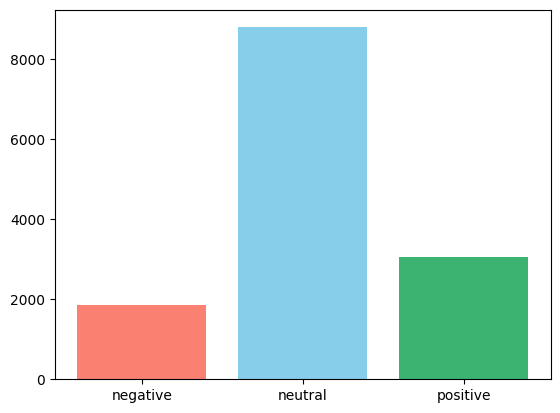

In [105]:
import matplotlib.pyplot as plt

heights = [
    len(np.where(data["labels"] == 0)[0]),
    len(np.where(data["labels"] == 1)[0]),
    len(np.where(data["labels"] == 2)[0])
]

plt.bar(x=[0, 1, 2], height=heights, tick_label=["negative", "neutral", "positive"], color=["salmon", "skyblue", "mediumseagreen"])

Based on the barchart, while the number of "neutral" labels exceed the other two labels, there is still significant data from the other two labels to carry out training.

## Create train-test split for data

The data will be split into 80% for training and validation, and 20% for testing. The training data will be further split subsequently into train and validation data.

In [42]:
from sklearn.model_selection import train_test_split

train_data, test_data_original = train_test_split(data, test_size=0.2, shuffle=True, random_state=4222)

## Remove parts non-essential parts of text data

Parts of the text, such as URLs, hashtags and username tags, are not useful in helping the model to identify the sentiment. Hence, we will be removing them to help our model focus on what is important.

In [19]:
def regex_cleanup(data):
    # regex cleaning to remove URLs
    data['title'] = data['title'].replace(to_replace=r'https?:\/\/.*[\r\n]*',value='',regex=True)

    # regex remove hashtags, newline and twitter usernames (@)
    data['title'] = data['title'].replace(to_replace=r'#',value='',regex=True)
    data['title'] = data['title'].replace(to_replace=r'\n',value='',regex=True)
    data['title'] = data['title'].replace(to_replace=r'@[^\s]+',value='',regex=True)

    # remove symbols
    symbol_pattern = r'[!@#%^&*()_+{}:;"\'<>,.?\|\/`~0-9]'
    data['title'] = data['title'].str.replace(symbol_pattern, '', regex=True)

regex_cleanup(train_data)

In [8]:
import nltk
from nltk.corpus import words
nltk.download("words")
nltk.download('punkt')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
from unidecode import unidecode

def remove_non_english(cell):
    if isinstance(cell, str):
        # convert non-ASCII characters to their closest ASCII representation
        ascii_text = unidecode(cell)

        # filter out words that do not consist of alphabets
        english_words = [word for word in ascii_text.split() if word.isalpha()]

        # join filtered words back into a string
        cleaned_text = ' '.join(english_words)

        return cleaned_text
    elif isinstance(cell, (float, int)):
        # convert float or int to string
        return str(cell)
    else:
        return cell

new_train_data = train_data.copy()
new_train_data["title"] = new_train_data["title"].apply(remove_non_english)

In [10]:
print(len(new_train_data))
new_train_data.replace("", float("NaN"), inplace=True)
cleaned_data = new_train_data.dropna()
print(len(cleaned_data))

10968
10946


## Using NER to obtain the entities involved in each news title

The final NER is a combination of results from using spaCy and BERT to identify the entities.

In [21]:
import spacy

nlp = spacy.load("en_core_web_sm")
def perform_ner(text):
    doc = nlp(text)
    organizations = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    return organizations

cleaned_data['NER'] = cleaned_data['title'].apply(perform_ner)
spacy_results = cleaned_data.NER.tolist()

In [22]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

def refine_org_name(ner_results):
    orgs_list = []
    org_name = ""
    # A set of common words not typically part of an organization name
    non_org_keywords = {
        'reports', 'results', 'quarter', 'earnings', 'profit', 'loss', 'revenue',
        'confirms', 'increase', 'delivers'
    }

    for result in ner_results:

        entity = result['entity']
        word = result['word']

        # check for first org occurence
        subword_flag = False
        if entity == 'B-ORG':
          # check if subword
          if word[0:2] == "##":
            word = word.replace('##', '')
            org_name += word
            subword_flag = True
          else:
            #add prev org to list
            if len(org_name) > 0:
              orgs_list.append(org_name.strip())
            org_name = word
        # check for I org subword
        elif entity == 'I-ORG':
          if word[0:2] == "##":
            word = word.replace('##', '')
            org_name += word
        # check for I org but not subword
          elif(word.lower() not in non_org_keywords):
            org_name += f" {word}"

    if org_name.strip() not in orgs_list and org_name:
      orgs_list.append(org_name.strip())

    return orgs_list


# Use the refined function to reconstruct the organization name
def BERT_NER(dataset):
  tokenizer = AutoTokenizer.from_pretrained("butchland/bert-finetuned-ner")
  model = AutoModelForTokenClassification.from_pretrained("butchland/bert-finetuned-ner")
  nlp = pipeline("ner", model=model, tokenizer=tokenizer)
  NER_res = []

  for sentence in dataset:
    sentence_orgs = refine_org_name(nlp(sentence))
    NER_res.append(sentence_orgs)
  return NER_res

tests = cleaned_data.title.tolist()
bert_results = BERT_NER(tests)

In [14]:
def combine_results(spacy, bert):
    combined_results = []
    for orgs_spacy, orgs_bert in zip(spacy, bert):
      if orgs_bert:
        combined_results.append(orgs_bert)
      elif orgs_spacy:
        combined_results.append(orgs_spacy)
      else:
        combined_results.append('No Entity Recognised')
    return combined_results

NER_col_results = combine_results(spacy_results, bert_results)
cleaned_data['Entities'] = NER_col_results

cleaned_data.head()

<ipython-input-14-c1ff872885cb>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Entities'] = NER_col_results


,title,labels,NER,Entities
4128,Watts Water Technologies EPS beats by beats on...,2,[Watts Water Technologies EPS],[Watts Water Technologies]
2482,The solar panel market could drop by this year...,0,[],No Entity Recognised
5533,Motorola Solutions stock fair value estimate r...,2,"[Motorola Solutions, MKM Partners]","[Motorola Solutions, MKM Partners]"
9069,Highlight Democrats and the White House reach ...,1,"[the White House, USMCA]","[the White House, USMCA]"
9116,How to Find Cheap Stocks Trading Under Nasdaq,1,[Nasdaq],[Nasdaq]


##### checkpoint

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# saving cleaned_data to csv
# cleaned_data.to_csv("/content/gdrive/My Drive/BT4222/cleaned_data_NER.csv")

# reading cleaned_data from csv
cleaned_data = pd.read_csv("/content/gdrive/My Drive/BT4222/cleaned_data_NER.csv", index_col="Unnamed: 0")

## Lemmatize data


While lemmatization is considered computationally more expensive than stemming due to its reliance on a linguistic database, our team believes that lemmatization is superior because it yields complete English words, whereas stemming can result in incomplete or non-English words.

In [5]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# resetting the index since it got shuffled by the train-test split
# necessary to ensure the step that follows this goes well
cleaned_data = cleaned_data.reset_index()

In [6]:
# Create a WordNetLemmatizer object for lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(text):
    """
    Lemmatizes a given text by tokenizing it into words,
    lemmatizing each word, and then rejoining them into a sentence.

    Parameters:
    - text (str): The input text to be lemmatized.

    Returns:
    - lemmatized_sentence (str): The lemmatized sentence.
    """
    # Tokenize the sentence into words
    words = word_tokenize(text)

    # Lemmatize each word and convert to lowercase
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words]

    # Join the lemmatized words back into a sentence
    lemmatized_sentence = ' '.join(lemmatized_words)

    return lemmatized_sentence

def lemmatize_dataset(sentences):
    """
    Lemmatizes an entire dataset of sentences using the lemmatize_sentence function.

    Parameters:
    - sentences (pd.Series): A Pandas Series containing the sentences to be lemmatized.

    Returns:
    - lemmatized (list) : A list of lemmatized sentences.
    """
    # Initialize an empty list to store lemmatized sentences
    lemmatized = []

    # Iterate through each sentence in the dataset
    for sentence in sentences:
        # Lemmatize the current sentence and append to the list
        lemmatized.append(lemmatize_sentence(sentence))

    return lemmatized

# Lemmatize the 'title' column in the 'data' DataFrame
cleaned_data["title"] = pd.Series(lemmatize_dataset(cleaned_data["title"]))

cleaned_data.head()

,index,title,labels,NER,Entities
0,4128,watt water technology eps beat by beat on revenue,2,['Watts Water Technologies EPS'],['Watts Water Technologies']
1,2482,the solar panel market could drop by this year...,0,[],No Entity Recognised
2,5533,motorola solution stock fair value estimate ra...,2,"['Motorola Solutions', 'MKM Partners']","['Motorola Solutions', 'MKM Partners']"
3,9069,highlight democrat and the white house reach a...,1,"['the White House', 'USMCA']","['the White House', 'USMCA']"
4,9116,how to find cheap stock trading under nasdaq,1,['Nasdaq'],['Nasdaq']


## Create train-validation split for training data

20% of the training data will be used for validation (and hyperparameter tuning). This means that the overall split of data into train : validation : test is 6 : 2 : 2.

In [9]:
cleaned_data = cleaned_data[~cleaned_data["title"].isnull()]

X_train, X_val, y_train, y_val = train_test_split(
    cleaned_data["title"], cleaned_data["labels"], test_size=0.2, shuffle=True, random_state=4222)

# Feature Engineering

The features we have chosen for our model are the TF-IDF of unigrams and bigrams. These have proven to be the most effective for our particular use case, based on the validation accuracy that they yield.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

ngram_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_all_ngrams = ngram_vectorizer.fit_transform(X_train)
X_val_all_ngrams = ngram_vectorizer.transform(X_val)
X_train_all_ngrams = X_train_all_ngrams.todense()
X_val_all_ngrams = X_val_all_ngrams.todense()

X_train_all_ngrams = np.array(X_train_all_ngrams)
X_val_all_ngrams = np.array(X_val_all_ngrams)

# Model Training

The model that we will be using is a stacked model. The base-learners are Multinomial Naive Bayes, Support Vector Machine, Logistic Regression, and Random Forest. They will all be used to perform classification of sentiment.

Our meta-learner of choice is Support Vector Machine. Using the prediction confidence of the base-learners as input, the meta-learner will come up with a single prediction for the final sentiment of the input data.

One thing to note is that the Support Vector Machine does not have prediction probabilities available. To overcome this, the prediction confidence for the predicted class will be 1.0, and the prediction confidence for all other classes will be 0.0.

## Fine-tuning hyperparameters of base-learners

The hyperparameters for the base-learners are fine-tuned over a fixed number of trials, using an external library called `optuna`.

First, the hyperparameters to be fine-tuned, and their range of values are maunally chosen in a sensible manner.

Next, `optuna` helps to run trials to optimize the hyperparameter values, using a Bayesian Optimization algorithm. In simple terms, a set of hyperparameter values are chosen to be used for each trial, and the area from which these values are chosen is continually updated.

The algorithm has been set to maximise the validation accuracy.

Through previous experiments, only Multinomial Naive Bayes classifier has had significant (>5%) increase in validation accuracy through the hyperparameter finetuning. Hence, we will only be performing the fine-tuning for that base-learner here.

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [22]:
def train_model(X_train, X_val, y_train, y_val, model):
    """Used to train the model and return predictions on validation data"""

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return y_pred

def objective_MNB(trial, X_train, X_val, y_train, y_val):
    """Objective function for optuna to use for hyperparameter fine-tuning"""

    params = {
        "alpha": trial.suggest_float("alpha", 0.01, 1.0),  # additive smoothing parameter
    }

    y_pred = train_model(X_train, X_val, y_train, y_val, MultinomialNB(**params))

    # the return value will be maximised in the optimization algorithm
    return accuracy_score(y_val, y_pred)


In [44]:
mnb_best_params = None

# conduct trials to find best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_MNB(
    trial, X_train_all_ngrams, X_val_all_ngrams, y_train, y_val), n_trials=50)

# save best hyperparameters
mnb_best_params = study.best_params

# print validation accuracy obtained using default hyperparameters
y_preds = train_model(X_train_all_ngrams, X_val_all_ngrams, y_train, y_val, MultinomialNB())
print("Default params acc:", accuracy_score(y_val, y_preds))

# print validation accuracy obtained using fine-tuned hyperparameters
print("Best params:", mnb_best_params)
y_preds_2 = train_model(X_train_all_ngrams, X_val_all_ngrams, y_train, y_val, MultinomialNB(**mnb_best_params))
print("Best params acc:", accuracy_score(y_val, y_preds_2))
print()

Default params acc: 0.7200913242009133
Best params: {'alpha': 0.13981459419680037}
Best params acc: 0.8013698630136986



In [10]:
# mnb_best_params = {'alpha': 0.13981459419680037}

Now, we will be training the base-learners using their best/default hyperparameters, to obtain our final base-learners.

In [19]:
trained_base_learners = [
    MultinomialNB(**mnb_best_params),
    SGDClassifier(loss="hinge"),
    SGDClassifier(loss="log_loss"),
    RandomForestClassifier()
]

for clf in trained_base_learners:
    clf.fit(X_train_all_ngrams, y_train)

    preds = clf.predict(X_val_all_ngrams)
    print("Classifier:", clf)
    print("Validation Accuracy:", accuracy_score(y_val, preds))
    print()

Classifier: MultinomialNB(alpha=0.13981459419680037)
Validation Accuracy: 0.8013698630136986

Classifier: SGDClassifier()
Validation Accuracy: 0.8168949771689498

Classifier: SGDClassifier(loss='log_loss')
Validation Accuracy: 0.7840182648401827

Classifier: RandomForestClassifier()
Validation Accuracy: 0.7885844748858447



We can see from the above that the Support Vector Machine classifier performed the best, with a 81.689% validation accuracy.

## Obtain input for meta-learner

The input for the meta-learner will be the prediction probabilities for each classifier for all classes. They will be concatenated together before being fed into the meta-learner.

In [15]:
from sklearn.preprocessing import OneHotEncoder

def get_proba(clfs, X, prob=1.0):
    """Get concatenated prediction probabilities for all classes from all classifiers"""

    preds_probs = []
    for clf in clfs:
        if hasattr(clf, "predict_proba"):  # for all classifiers except SVM
            preds_probs.append(clf.predict_proba(X))
        else:  # for SVM
            enc = OneHotEncoder()
            # fit encoder with all possible labels
            enc.fit(np.expand_dims(np.array([0, 1, 2]), axis=1))
            # transform predictions to one-hot encodings to represent their prediction probabilities
            preds_probs.append(enc.transform(np.expand_dims(clf.predict(X), axis=1)).toarray() * prob)
    collated = np.concatenate(preds_probs, axis=1)
    return collated

In [28]:
# get the train and validation prediction probabilities
train_probs = get_proba(trained_base_learners, X_train_all_ngrams)
val_probs = get_proba(trained_base_learners, X_val_all_ngrams)

## Fine-tuning hyperparameters of meta-learner

The chosen meta-learner is Support Vector Machine, based on previous trials that have shown that using SVM will result in the best validation accuracy.

The hyperparameters of the meta-learner will be fine-tuned in the same way as that for the base-learners, using `optuna`.

In [33]:
def objective_meta(trial, X_train, X_val, y_train, y_val, clf):
    """Objective function to be used to optimize the hyperparameters of meta-learner"""

    params = {
        "loss": "hinge",
        "alpha": trial.suggest_float("alpha", 0.0001, 0.1),  # regularisation parameter
        "max_iter": trial.suggest_int("max_iter", 1000, 10000),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"]),
    }

    model = clf(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return accuracy_score(y_val, preds)

In [35]:
meta_learner = SGDClassifier

# conduct trials to find best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_meta(trial, train_probs, val_probs, y_train, y_val, meta_learner), n_trials=500)
meta_learner_best_params = study.best_params

# print results achieved using default hyperparameters
model = meta_learner()
model.fit(train_probs, y_train)
y_preds = model.predict(val_probs)
print("Default params acc:", accuracy_score(y_val, y_preds))

# print results achieved using fine-tuned hyperparameters
print("Best params:", meta_learner_best_params)
model = meta_learner(**meta_learner_best_params)
model.fit(train_probs, y_train)
y_preds_2 = model.predict(val_probs)
print("Best params acc:", accuracy_score(y_val, y_preds_2))

Default params acc: 0.7945205479452054
Best params: {'alpha': 0.004278536844289651, 'max_iter': 7272, 'penalty': 'elasticnet'}
Best params acc: 0.8223744292237443


In [11]:
# meta_learner_best_params = {'alpha': 0.004278536844289651, 'max_iter': 7272, 'penalty': 'elasticnet'}

# Testing the Final Model

The test data, which has been unseen by the model, will be used to evaluate the final model performance.

## Final training of base- and meta-learners using training and validation data

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# fit final vectorizer using train + validation data
ngram_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_final = ngram_vectorizer.fit_transform(cleaned_data["title"]).todense()
X_train_final = np.array(X_train_final)

y_train_final = cleaned_data["labels"]

In [12]:
# train all the base-learners using train + validation data
trained_base_learners_final = [
    MultinomialNB(**mnb_best_params),
    SGDClassifier(loss="hinge"),
    SGDClassifier(loss="log_loss"),
    RandomForestClassifier()
]

for clf in trained_base_learners_final:
    clf.fit(X_train_final, y_train_final)

In [16]:
# obtain final train probabilities
train_probs_final = get_proba(trained_base_learners_final, X_train_final)

In [18]:
# train final meta-learner using train + validation probabilities
meta_learner = SGDClassifier
trained_meta_learner = meta_learner(**meta_learner_best_params)
trained_meta_learner.fit(train_probs_final, y_train_final)

SGDClassifier(alpha=0.004278536844289651, max_iter=7272, penalty='elasticnet')

## Save final models

The final models and vectorizer are pickled, so they can be loaded any time for future use.

In [40]:
import pickle
import os

dir = "/content/gdrive/My Drive/BT4222/Simple Models"

pickle.dump(trained_base_learners_final[0], open(os.path.join(dir, "BL_MNB.pkl"), 'wb'))
pickle.dump(trained_base_learners_final[1], open(os.path.join(dir, "BL_SVM.pkl"), 'wb'))
pickle.dump(trained_base_learners_final[2], open(os.path.join(dir, "BL_LR.pkl"), 'wb'))
pickle.dump(trained_base_learners_final[3], open(os.path.join(dir, "BL_RF.pkl"), 'wb'))
pickle.dump(trained_meta_learner, open(os.path.join(dir, "ML_SVM.pkl"), 'wb'))
pickle.dump(ngram_vectorizer, open(os.path.join(dir, "vectorizer.pkl"), 'wb'))

## Pre-processing and feature extraction of test data

The processes here are the same as those that were performed on the train and validation data above. First, the data is cleaned, then the entities are detected, then the features for model input are extracted.

In [24]:
# cleaning the test data
test_data = test_data_original.copy()
regex_cleanup(test_data)
test_data["title"] = test_data["title"].apply(remove_non_english)
test_data.replace("", float("NaN"), inplace=True)
test_data.dropna(inplace=True)

In [25]:
# peforming NER on test data
test_data['NER'] = test_data['title'].apply(perform_ner)
spacy_results = test_data.NER.tolist()
tests = test_data.title.tolist()
bert_results = BERT_NER(tests)
NER_col_results = combine_results(spacy_results, bert_results)
test_data['Entities'] = NER_col_results

test_data.head()

,title,labels,NER,Entities
3046,Mimecast after downside Q EBITDA forecast,0,[],[EBITDA]
9421,Platts Commodity Charts To Watch This Week,1,[],[Platts Commodity]
8597,Atlantic Storm Poised to Send Europe to New Wi...,1,[New Wind Power Records],"[Atlantic Storm, New Wind Power Records]"
8918,Frances Top Female CEO Becomes a Stranded Asset,1,[],No Entity Recognised
9066,Highlight Carnival CEO Arnold W Donald discuss...,1,[],[Highlight Carnival]


In [26]:
# test_data.to_csv("/content/gdrive/My Drive/BT4222/test_data_NER.csv")

In [27]:
# lemmatize titles
test_data = test_data.reset_index()
test_data["title"] = pd.Series(lemmatize_dataset(test_data["title"]))

test_data.head()

,index,title,labels,NER,Entities
0,3046,mimecast after downside q ebitda forecast,0,[],[EBITDA]
1,9421,platts commodity chart to watch this week,1,[],[Platts Commodity]
2,8597,atlantic storm poised to send europe to new wi...,1,[New Wind Power Records],"[Atlantic Storm, New Wind Power Records]"
3,8918,france top female ceo becomes a stranded asset,1,[],No Entity Recognised
4,9066,highlight carnival ceo arnold w donald discus ...,1,[],[Highlight Carnival]


In [28]:
# set the X and y test variables
X_test = test_data["title"]
y_test = test_data["labels"]

In [29]:
# feature extraction from test data
X_test_all_ngrams = ngram_vectorizer.transform(X_test)
X_test_all_ngrams = X_test_all_ngrams.todense()
X_test_all_ngrams = np.array(X_test_all_ngrams)

## Obtaining predictions from test data

The extracted features will be fed into the base-learners. The prediction probability outputs from the base-learners will then be fed into the meta-learner for the final prediction

In [109]:
# preliminary test accuracies using each of the base-learners (benchmark)
for clf in trained_base_learners_final:
    preds = clf.predict(X_test_all_ngrams)
    print("Classifier:", clf)
    print("Test Accuracy:", accuracy_score(y_test, preds))
    print()

Classifier: MultinomialNB(alpha=0.13981459419680037)
Test Accuracy: 0.7775748721694667

Classifier: SGDClassifier()
Test Accuracy: 0.8005843681519357

Classifier: SGDClassifier(loss='log_loss')
Test Accuracy: 0.7593133674214755

Classifier: RandomForestClassifier()
Test Accuracy: 0.7815924032140248



In [31]:
# getting base-learner prediction probabilities
test_probs = get_proba(trained_base_learners_final, X_test_all_ngrams)

In [32]:
# get final prediction
y_preds = trained_meta_learner.predict(test_probs)

## Evaluation of test predictions

For the final model evaluation, we will be using a range of different metrics, so as to obtain a fair and holistic assessment of our model performance.

In [38]:
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay)

print("Accuracy:", accuracy_score(y_test, y_preds))
print("Precision:", precision_score(y_test, y_preds, average="macro"))
print("Recall:", recall_score(y_test, y_preds, average="macro"))
print("F1 Score:", f1_score(y_test, y_preds, average="macro"))

Accuracy: 0.8064280496712929
Precision: 0.8009791067260883
Recall: 0.6800603386492784
F1 Score: 0.7219811210474019


[[ 180  144   38]
 [  20 1662   88]
 [  14  226  366]]


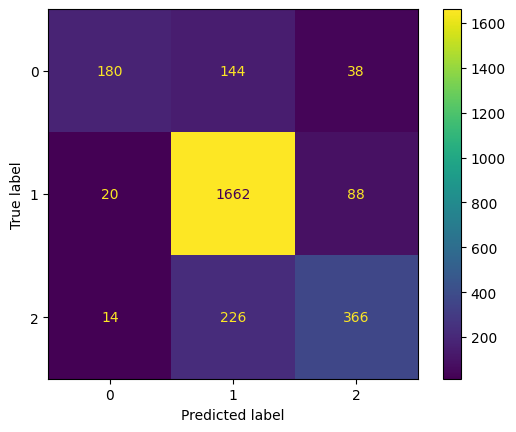

In [39]:
# obtain and plot confusion matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

## Final model outputs

Now, we will combine all the work we have done to present the final dataframe of outputs.

In [ ]:
# tidying up the dataframe
final_entities = test_data.drop(columns=["NER", "labels", "title"])
test_data_original = test_data_original.reset_index()

# merge the predictions with the original article titles
final_output_df = pd.merge(test_data_original, final_entities, on="index")
final_output_df["pred_labels"] = y_preds

In [69]:
# final_output_df will consist of the original article title, ground truth labels,
# predicted entities, and predicted labels
final_output_df

,index,title,labels,Entities,pred_labels
0,3046,$MIME - Mimecast -7.6% after downside Q4 EBITD...,0,[EBITDA],0
1,9421,Platts: 5 Commodity Charts To Watch This Week ...,1,[Platts Commodity],1
2,8597,Atlantic Storm Poised to Send Europe to New Wi...,1,"[Atlantic Storm, New Wind Power Records]",1
3,8918,France's Top Female CEO Becomes a Stranded Asset,1,No Entity Recognised,1
4,9066,Highlight: Carnival CEO Arnold W. Donald discu...,1,[Highlight Carnival],1
...,...,...,...,...,...
2733,3953,"Wetherspoon plans new pubs around Britain, cre...",2,[Wetherspoon],1
2734,5151,$AKCA (+1.0% pre) Akcea and Ionis $IONS launch...,2,"[Akcea, Ionis, SA]",2
2735,12006,took $PLAY #4,1,No Entity Recognised,1
2736,609,Vision Marine Technologies Expands Electric Bo...,2,"[Vision Marine Technologiespan, Electric Boat ...",2


## Error analysis

In [74]:
error_analysis_df = final_output_df.drop(columns=["index", "Entities"])
error_analysis_df = error_analysis_df.iloc[np.where(y_preds != y_test)[0]]

In [78]:
error_analysis_df

,title,labels,pred_labels
6,$TOL - Now Is The Time To Build A Position In ...,2,1
8,La Jolla Pharmaceutical to reassess continued ...,0,1
9,Just Energy Announces Granting of Reverse Vest...,2,1
10,California Intensifies Fossil Fuel Fight With ...,0,1
11,$KOS - Kosmos inks Greater Tortue LNG supply d...,2,1
...,...,...,...
2713,Labrador Uranium Completes 2022 Field Season –...,2,1
2714,$WORK - Slack -5% after statement on IBM https...,0,2
2727,Egypt's inflation inched higher for a third st...,0,1
2733,"Wetherspoon plans new pubs around Britain, cre...",2,1


In [111]:
# error_analysis_df.to_csv("/content/gdrive/My Drive/BT4222/Simple Models/error_df.csv")

In [104]:
print("Total no. of negative articles:", len(np.where(final_output_df["labels"] == 0)[0]))
print("Total no. of positive articles:", len(np.where(final_output_df["labels"] == 1)[0]))
print("Total no. of neutral articles:", len(np.where(final_output_df["labels"] == 2)[0]))

Total no. of negative articles: 362
Total no. of positive articles: 1770
Total no. of neutral articles: 606


In [110]:
print("Total no. of negative articles predicted:", len(np.where(final_output_df["pred_labels"] == 0)[0]))
print("Total no. of positive articles predicted:", len(np.where(final_output_df["pred_labels"] == 1)[0]))
print("Total no. of neutral articles predicted:", len(np.where(final_output_df["pred_labels"] == 2)[0]))

Total no. of negative articles predicted: 214
Total no. of positive articles predicted: 2032
Total no. of neutral articles predicted: 492
